# Coronavirus tweets NLP

- word cloud
- lda

## Environment

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Data

In [2]:
train = pd.read_csv('../data/Corona_NLP_train.csv', encoding = 'latin1')
test = pd.read_csv('../data/Corona_NLP_test.csv', encoding = 'latin1')

df = pd.concat([train, test])
df.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


## Data cleaning

In [4]:
import string
import re

def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def lower(text):
    low_text = text.lower()
    return low_text

def remove_num(text):
    remove = re.sub(r'\d+', '' ,text)
    return remove

def remove_punctuation(text):
    clean_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: remove_urls(x)) \
                                               .apply(lambda x: remove_html(x)) \
                                               .apply(lambda x: lower(x)) \
                                               .apply(lambda x: remove_num(x)) \
                                               .apply(lambda x: remove_punctuation(x))


def classes_def(x):
    if x ==  'Extremely Positive' or x == 'Positive':
        return "positive"
    elif x == "Extremely Negative" or x == 'Negative':
        return "negative"
    else:
        return "neutral"
    
train['Sentiment'] = train['Sentiment'].apply(lambda x: classes_def(x))

train.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet Sentiment  
0             menyrbie philgahan chrisitv  and  and    neutral  
1  advice talk to your neighbours family to excha...  positive  
2  coronavirus australia woolworths to give elder...  positive  
3  my food stock is not the only one which is emp...  positive  
4  me ready to go at supermarket during the covid...  negative

## Word Cloud

### Whole data

In [6]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=10, max_df=.3, stop_words='english')
train_cv = cv.fit_transform(train['OriginalTweet'])
word_count = train_cv.sum(axis = 0)
word_freq = [(word, word_count[0, idx]) for word, idx in cv.vocabulary_.items()]
word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)

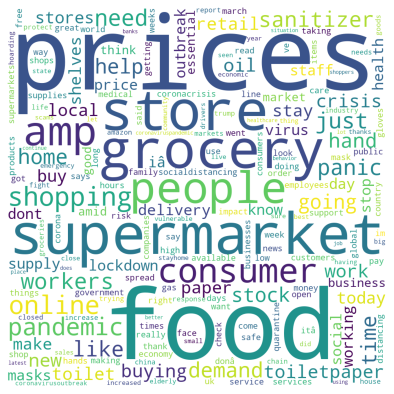

In [7]:
wordcloud = WordCloud(background_color='white',
                      width = 1000, height = 1000).generate_from_frequencies(dict(word_freq))

plt.figure(figsize=(7,7), dpi = 300)
plt.axis('off')
plt.imshow(wordcloud)
plt.show();

### Separated

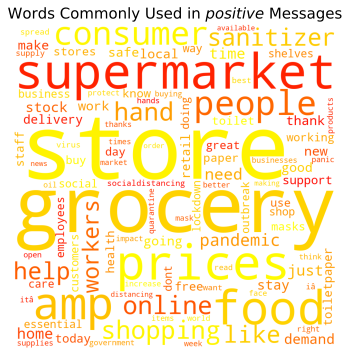

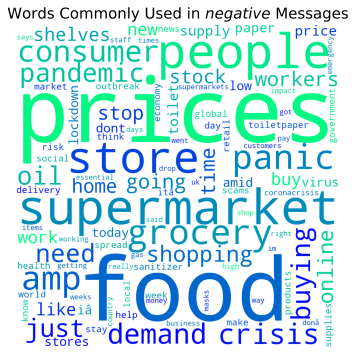

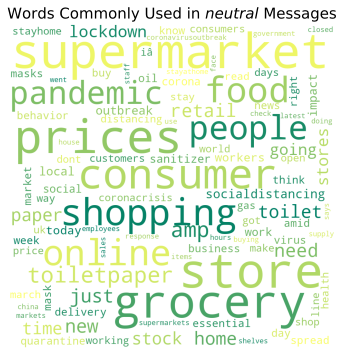

In [8]:
for label, cmap in zip(['positive', 'negative', 'neutral'],
                       ['autumn', 'winter', 'summer']):
    sep = train[train['Sentiment'] == label]['OriginalTweet']
    cv = CountVectorizer(min_df=10, max_df=.3, stop_words='english')
    sep_cv = cv.fit_transform(sep)
    word_count = sep_cv.sum(axis = 0)
    word_freq = [(word, word_count[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
    
    plt.figure(figsize=(6, 6), dpi = 300)
    wc = WordCloud(width=1000, height=1000, background_color='white', colormap=cmap, max_words=100)
    wc.generate_from_frequencies(dict(word_freq))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=15)
    plt.show()

We observed pretty similar frequent words in both negative and positive wordcloud like food, grocery, prices, which means that people are most concerned about their food supply and grocery price, and the most effective positive aspect of these words might be a sufficient food supply and ample groceries. The supply of daily grocery and their price can effect people on twitter easily. 

## LDA

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=.3, min_df=15, ngram_range=[1, 2], stop_words='english')
train_tfidf = tfidf.fit_transform(train['OriginalTweet'])
train_tfidf.shape

(41157, 7186)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, n_jobs=-1, random_state=123)
train_lda = lda.fit_transform(train_tfidf)
train_lda.shape

(41157, 10)

In [ ]:
vocab = tfidf.get_feature_names()
vocab = [x.replace(' ', '_') for x in vocab]

for topic_idx, topic in enumerate(lda.components_):
    statement = 'Topic {:#2d}: '.format(topic_idx)
    statement += ' '.join([vocab[i] for i in np.argsort(topic)[:-10-1:-1]])
    print(statement)

Topic  0: supermarket people social food distancing social_distancing stores store spread closed
Topic  1: panic food buying panic_buying supermarket people stop shelves supermarkets need
Topic  2: workers store grocery grocery_store supermarket staff thank employees store_workers work
Topic  3: prices oil oil_prices gas market demand low pandemic gas_prices economy
Topic  4: online shopping food demand help online_shopping store grocery delivery local
Topic  5: store grocery grocery_store supermarket toiletpaper toilet paper toilet_paper people just
Topic  6: consumer impact retail behavior pandemic crisis consumers consumer_behavior amp new
Topic  7: sanitizer hand hand_sanitizer masks prices hands coronavirus_covid face sanitizers soap
Topic  8: shopping online online_shopping grocery grocery_shopping supermarket online_grocery fresh covid_coronavirus store
Topic  9: scams prices consumer price stay gouging price_gouging scammers people food
